In [62]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from utility_funcs import *

In [63]:
path = './dataset_objects/' + MODE + '/4_dataset_K_3.pt'

In [64]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = int(path.split("/")[-1].split('_')[0])     # число атомов
    K = int(path.split("/")[-1].split('_')[-1].split('.')[0])     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 32

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [65]:
def plot_k_dim_f_norm_from_x_norm(data_sample, figsize=(15, 10), fontsize=18):
    '''

    Функция строит зависимость таргета от X

    data_sample - итерируемый объект из тьюплов вида: (x, f_k_dim, f_3d, pinv_A)

    '''
    plt.figure(figsize=figsize)
    x = torch.stack([elem[0][0].squeeze() for elem in data_sample])

    y = torch.stack([elem[1][0].squeeze() for elem in data_sample])

    plt.scatter(x, y, label='y(x)')
    plt.title('Зависимость $Y_{target}(X)$', fontsize=fontsize)

    None

In [66]:
def make_predictions_and_get_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    returns: Y_pred, Y_target    
    '''

    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices)
    metric = criterion(Y_pred, Y_target)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = criterion(Y_pred, Y_target)
    
    print(f'MSE:{metric}')

    return Ys

In [67]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if show_3D_quality:
            # print(pinv_As.size(), torch.unsqueeze(outputs.to(torch.float), 2).size())
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_size
    if show_3D_quality:
        train_MSE = running_MSE / processed_size
        return train_loss, train_MSE
    
    return train_loss

In [68]:
def eval_epoch(model, val_loader, criterion, show_3D_quality):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if show_3D_quality:
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    if show_3D_quality:
        val_MSE = running_MSE / processed_size
        return val_loss, val_MSE

    return val_loss

In [69]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=nn.MSELoss(), show_3D_quality=False):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    if show_3D_quality:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} train_mse: {t_mse:0.4f} val_mse: {v_mse:0.4f}"
    else:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            if show_3D_quality:
                train_loss, train_mse = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality)
                val_loss, val_mse = eval_epoch(model, val_loader, criterion, show_3D_quality)
            else:
                train_loss = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality)
                val_loss = eval_epoch(model, val_loader, criterion, show_3D_quality)
            history.append((train_loss, val_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [70]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.FC = nn.Sequential(
            # nn.BatchNorm1d(flattened_size),

            nn.Linear(flattened_size, 64),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(64),

            nn.Linear(64, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 256),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, output_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [71]:
train_data, val_data, train_dataloader, val_dataloader = recieve_loaders(
    take_one_projection_for_data=0,
    path=path,
    cut_size=None
    )

In [72]:
model = SingleNet(
    output_size=1,

    # activation=nn.Sigmoid(),
    activation=nn.ReLU(),

).to(CFG.device)

# model = nn.Linear(1, 1)

# model = nn.Sequential(
#     nn.Linear(CFG.K ** 2, 8),
#     nn.ReLU(),
#     # nn.Dropout(0.5),
#     # nn.BatchNorm1d(8),

#     nn.Linear(8, 32),
#     nn.ReLU(),
#     # nn.Dropout(0.5),
#     # nn.BatchNorm1d(32),

#     nn.Linear(32, CFG.K)
# )

optimizer = optim.Adam(model.parameters(), lr=5e-2, betas=(0.9, 0.999), weight_decay=0)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

model

SingleNet(
  (FC): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [73]:
history = train(
    train_loader=train_dataloader, val_loader=val_dataloader, model=model, optimizer=optimizer,
    
    scheduler=exp_scheduler,
    scaler=None,
    
    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),

    # show_3D_quality=True,    # ПОКА ЧИСТО ТЕСТЮ НА ОДНОЙ ПРОЕКЦИИ И ТАМ РАЗМЕРНОСТИ НЕ СОВПАДАЮТ
    
    epochs=10
)


Epoch 001 train_loss: 8.9540 val_loss: 0.1980

Epoch 002 train_loss: 0.5590 val_loss: 0.0978

Epoch 003 train_loss: 0.1390 val_loss: 0.0347

Epoch 004 train_loss: 0.0416 val_loss: 0.0142

Epoch 005 train_loss: 0.0158 val_loss: 0.0090

Epoch 006 train_loss: 0.0127 val_loss: 0.0070

Epoch 007 train_loss: 0.0086 val_loss: 0.0061


epoch: 100%|██████████| 10/10 [00:00<00:00, 34.50it/s]


Epoch 008 train_loss: 0.0061 val_loss: 0.0050

Epoch 009 train_loss: 0.0060 val_loss: 0.0041

Epoch 010 train_loss: 0.0072 val_loss: 0.0051


In [74]:
Y_pred, Y_target = make_predictions_and_get_quality(model=model, data=val_data, same_axis=True)

Y_true = Y_target.squeeze().detach().numpy()
Y_pred = Y_pred.squeeze().detach().numpy()

MSE:0.005078377202153206


In [75]:
val_X = (torch.stack([elem[0] for elem in val_data]))

In [76]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

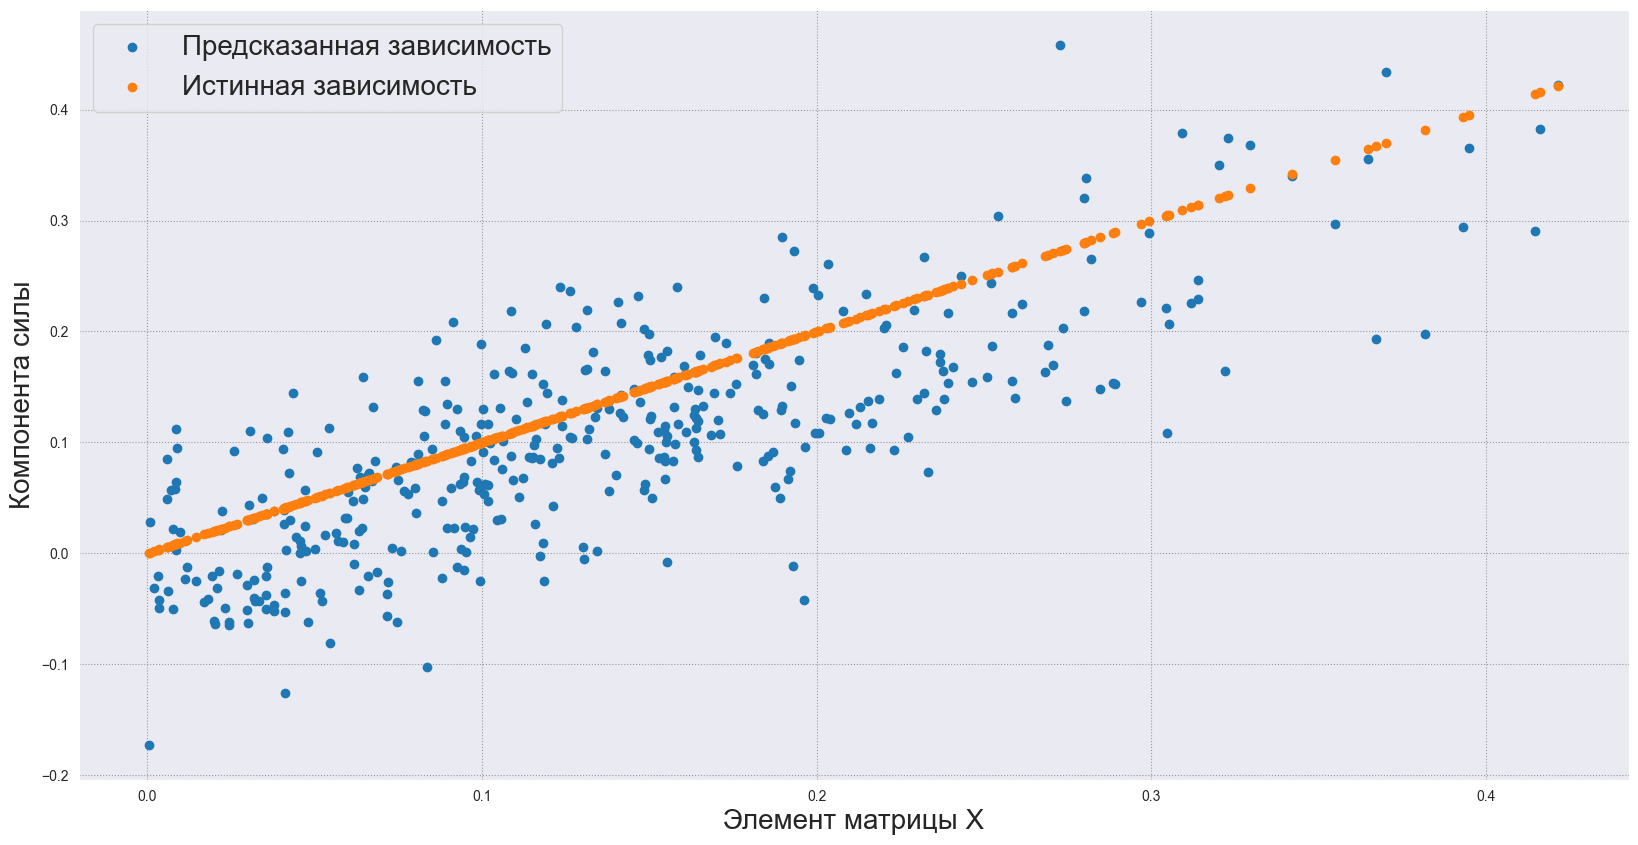

In [77]:
plot_2d_result(
    x11_val,
    y_pred=Y_pred,
    y_true=Y_true, 
    figsize=(20, 10)
)

In [ ]:
torch.load(path)